In [1]:
import gym
import numpy as np

from collections import defaultdict, deque
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


from IPython.display import clear_output

In [2]:
env = gym.make('Blackjack-v0')

In [61]:
class MCagent():
    def __init__(self, nA, gamma, epsilon_decay, epsilon_min, epsilon, alpha):
        '''
        Creates a Monte Carlo agent

        params:
        nA(int): Size of the action space
        gamma(float): Discount rate
        epsilon(float): Initial parameter for epsilon-greedy policy
        epsilon_decay(float): Decay rate of epislon
        epsilon_min(float): Minimum value of the epsilon
        alpha(float): Policy update parameter
        '''
        self.nA = nA
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.alpha = alpha
        self.memory = list()
        self.Q = defaultdict(lambda: np.zeros(self.nA))

    def act(self, state):
        '''
        Choose action to take based on epsilon-greedy policy

        params:
        state(tuple): Current state

        returns:
        action(int): Action to take by the agent
        '''
        if self.epsilon > np.random.random():
            return np.random.choice(np.arange(self.nA))
        else:
            return np.argmax(self.Q[state])

    def remember(self, state, action, reward):
        '''
        Stores cycle in the memory

        params:
        state(tuple): Current state
        action(int): Current action
        reward(int): Current reward
        '''
        self.memory.append((state, action, reward))

    def update_epsilon(self):
        '''
        Updates epsilon parameter
        '''
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon - self.epsilon_decay

    def update(self):
        '''
        Updates Q values
        '''
        self.update_epsilon()
        
        
        states, actions, rewards = zip(*self.memory)

        discount = np.array([self.gamma**i for i in range(len(states)+1)])

        for i in range(len(states)):
            G_t = sum(rewards[i:]*discount[:len(states)-i])
            old_Q = self.Q[states[i]][actions[i]]
            self.Q[states[i]][actions[i]] = old_Q + self.alpha*(G_t-old_Q)
        self.memory = list()

In [86]:
# hyperparameters
run_avg_rewards = list()
rewards = deque(maxlen=5000)
num_episodes = 300000
hyper = {
    'epsilon': 1.0,
    'epsilon_min': 0.001,
    'epsilon_decay': 0.999/num_episodes,
    'nA': 2,
    'gamma': 0.9,
    'alpha': 0.01}

In [87]:
agent = MCagent(**hyper)
for episode in range(1,num_episodes+1):
    total_reward = 0
    state = env.reset()
    while True:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward)
        state = next_state
        total_reward += reward
        if done:
            agent.update()
            rewards.append(total_reward)
            run_avg_rewards.append(np.mean(rewards))
            if episode % 10000 == 0:
                print('Episode {}/{} ... reward {:.2f} ... epsilon: {:.3f}'.format(episode,
                                                                                   num_episodes, np.mean(rewards), agent.epsilon))
            break

Episode 10000/300000 ... reward -0.38 ... epsilon: 0.967
Episode 20000/300000 ... reward -0.38 ... epsilon: 0.933
Episode 30000/300000 ... reward -0.36 ... epsilon: 0.900
Episode 40000/300000 ... reward -0.35 ... epsilon: 0.867
Episode 50000/300000 ... reward -0.35 ... epsilon: 0.834
Episode 60000/300000 ... reward -0.30 ... epsilon: 0.800
Episode 70000/300000 ... reward -0.32 ... epsilon: 0.767
Episode 80000/300000 ... reward -0.31 ... epsilon: 0.734
Episode 90000/300000 ... reward -0.29 ... epsilon: 0.700
Episode 100000/300000 ... reward -0.29 ... epsilon: 0.667
Episode 110000/300000 ... reward -0.26 ... epsilon: 0.634
Episode 120000/300000 ... reward -0.28 ... epsilon: 0.600
Episode 130000/300000 ... reward -0.24 ... epsilon: 0.567
Episode 140000/300000 ... reward -0.24 ... epsilon: 0.534
Episode 150000/300000 ... reward -0.25 ... epsilon: 0.501
Episode 160000/300000 ... reward -0.22 ... epsilon: 0.467
Episode 170000/300000 ... reward -0.19 ... epsilon: 0.434
Episode 180000/300000 .

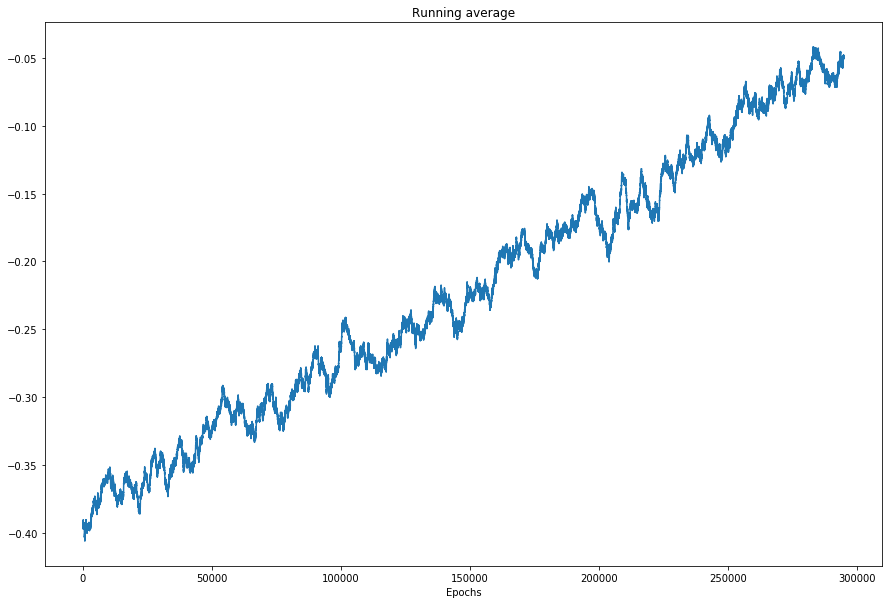

In [89]:
fig, ax = plt.subplots(figsize=[15,10])
ax.plot(run_avg_rewards[5000:])
ax.set_title('Running average')
ax.set_xlabel('Epochs');

In [90]:
policy = dict((k, np.argmax(v)) for k, v in agent.Q.items())

In [91]:
def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x, y, usable_ace) in policy:
            return policy[x, y, usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x, y, usable_ace) for x in x_range]
                      for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2),
                         vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0, 1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)', '1 (HIT)'])

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

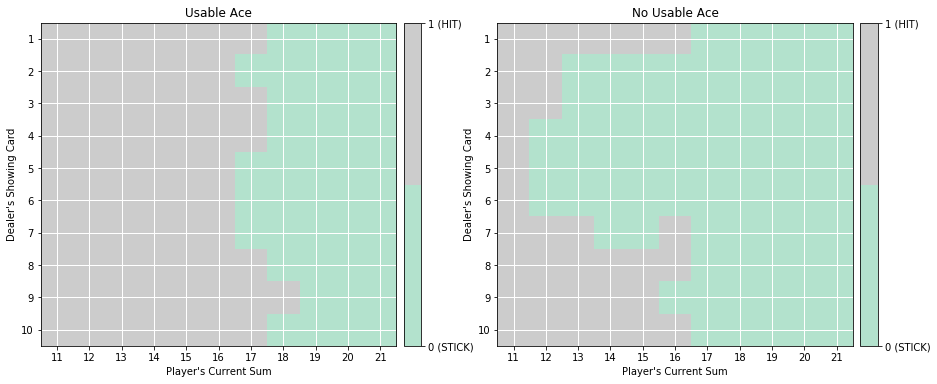

In [92]:
plot_policy(policy)

<img src='image.png'>

<h4 style='text-align:center'>Reinforcement Learning: An Introduction</h4>